Cargar librerias

In [190]:
import pandas as pd
import numpy as np
import utm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import math

Importar datos

In [191]:
filename = "datasets/flujo_15_8_2017.csv"
datos = pd.read_csv(filename,sep=";",)
datos = datos.iloc[1000:2315] #first 3700 rows have data
datos["DATETIME"] = pd.to_datetime(datos["FECHA"] + " " + datos["HORA"],format='%d/%m/%y %H:%M:%S')
datos.drop_duplicates(subset=['DATETIME'],inplace=True)
datos['ts'] = datos[['DATETIME']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
datos = datos[["DATETIME","ts", "LATITUD","LONGITUD","ALTITUD","VELOCIDAD","CONSUMO_TOTAL","CPNSUMO_INSTANTANEO"]]
datos.dropna(inplace=True)
datos["LATITUD"] = pd.to_numeric(datos.LATITUD.str.slice(0, 6) + datos.LATITUD.str.slice(7, ))
datos = datos[datos.LATITUD<0]
datos["LONGITUD"] = pd.to_numeric(datos.LONGITUD.str.slice(0, 7) + datos.LONGITUD.str.slice(8, ))
datos = datos[datos.LONGITUD<0]    
datos = datos[(datos["ALTITUD"]<4000) & (datos["ALTITUD"]>1800)]
datos.head()

,DATETIME,ts,LATITUD,LONGITUD,ALTITUD,VELOCIDAD,CONSUMO_TOTAL,CPNSUMO_INSTANTANEO
1000,2017-08-15 12:08:34,1502798914,-3.476099,-79.168671,2321.3,57.73,3091.94,13.10
1001,2017-08-15 12:08:36,1502798916,-3.476278,-79.168900,2321.3,57.69,3091.94,13.30
1002,2017-08-15 12:08:38,1502798918,-3.476464,-79.169121,2321.3,57.89,3091.95,13.40
1004,2017-08-15 12:08:40,1502798920,-3.476898,-79.169502,2321.3,58.28,3091.96,13.25
1005,2017-08-15 12:08:42,1502798922,-3.477153,-79.169647,2321.3,58.60,3091.97,13.65


Transformar coordenadas

In [192]:
utms = utm.from_latlon(datos["LATITUD"],datos["LONGITUD"],17,"S") #14Q for Mexico, 17S for Ecuador    
datos["x"] = utms[0]
datos["y"] = utms[1]
datos.head()

,DATETIME,ts,LATITUD,LONGITUD,ALTITUD,VELOCIDAD,CONSUMO_TOTAL,CPNSUMO_INSTANTANEO,x,y
1000,2017-08-15 12:08:34,1502798914,-3.476099,-79.168671,2321.3,57.73,3091.94,13.10,703443.268937,9.615585e+06
1001,2017-08-15 12:08:36,1502798916,-3.476278,-79.168900,2321.3,57.69,3091.94,13.30,703417.782179,9.615565e+06
1002,2017-08-15 12:08:38,1502798918,-3.476464,-79.169121,2321.3,57.89,3091.95,13.40,703393.182957,9.615544e+06
1004,2017-08-15 12:08:40,1502798920,-3.476898,-79.169502,2321.3,58.28,3091.96,13.25,703350.750075,9.615497e+06
1005,2017-08-15 12:08:42,1502798922,-3.477153,-79.169647,2321.3,58.60,3091.97,13.65,703334.581834,9.615468e+06


Agregar distancias, pendientes y velocidades

In [193]:
min_distance = 0.001
datos["last_x"] = utms[0].shift(1) #last observation
datos["last_y"] = utms[1].shift(1)
datos["last_height"] = datos["ALTITUD"].shift(1)
datos["last_ts"] = datos["ts"].shift(1)
datos["distance"] = np.sqrt((datos["x"]-datos["last_x"])**2 + (datos["y"]-datos["last_y"])**2)+min_distance
datos["slope"] = slopes = (datos["ALTITUD"]-datos["last_height"])/datos["distance"]
datos["ds"] = datos["ts"]  - datos["last_ts"] 
datos["speed"] = ((datos["distance"]/1000) / datos["ds"])*3600  #km/h
datos["sumdistance"] = np.cumsum(datos["distance"])
datos['ts'] = datos[['DATETIME']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
datos.dropna(inplace=True)
datos = datos.tail(-1)
datos = datos[["DATETIME","LATITUD","LONGITUD","ALTITUD","VELOCIDAD","CONSUMO_TOTAL","CPNSUMO_INSTANTANEO","distance", "sumdistance","slope", "speed"]]
datos.reset_index(inplace=True, drop=True)
datos.head()

,DATETIME,LATITUD,LONGITUD,ALTITUD,VELOCIDAD,CONSUMO_TOTAL,CPNSUMO_INSTANTANEO,distance,sumdistance,slope,speed
0,2017-08-15 12:08:38,-3.476464,-79.169121,2321.3,57.89,3091.95,13.40,32.036666,64.278855,0.0,57.665999
1,2017-08-15 12:08:40,-3.476898,-79.169502,2321.3,58.28,3091.96,13.25,64.003520,128.282375,0.0,115.206335
2,2017-08-15 12:08:42,-3.477153,-79.169647,2321.3,58.60,3091.97,13.65,32.480600,160.762975,0.0,58.465080
3,2017-08-15 12:08:44,-3.477430,-79.169754,2321.3,59.17,3091.98,13.75,32.861444,193.624419,0.0,59.150599
4,2017-08-15 12:08:46,-3.477718,-79.169830,2321.3,59.91,3091.99,13.70,32.951891,226.576310,0.0,59.313405


Graficas

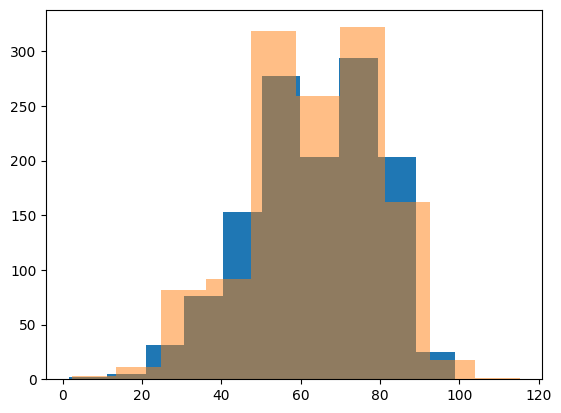

In [194]:
plt.hist(datos["VELOCIDAD"])
plt.hist(datos["speed"],alpha=0.5)
plt.show()

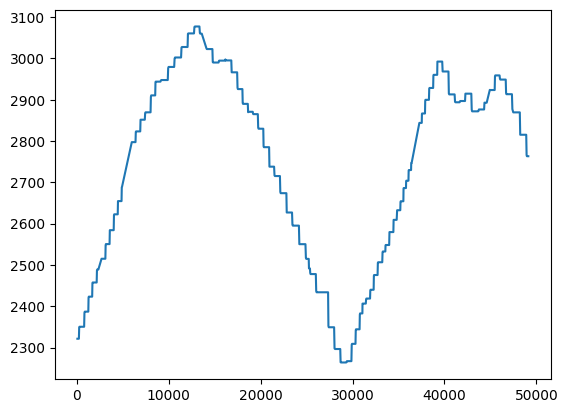

In [195]:
plt.plot(datos["sumdistance"],datos["ALTITUD"])
plt.show()

Encontrar gaps en altura

Min gap distance 33.400000000000205


,DATETIME,LATITUD,LONGITUD,ALTITUD,VELOCIDAD,CONSUMO_TOTAL,CPNSUMO_INSTANTANEO,distance,sumdistance,slope,speed,cluster
0,2017-08-15 12:08:38,-3.476464,-79.169121,2321.3,57.89,3091.95,13.40,32.036666,64.278855,0.0,57.665999,1.0
1,2017-08-15 12:08:40,-3.476898,-79.169502,2321.3,58.28,3091.96,13.25,64.003520,128.282375,0.0,115.206335,1.0
2,2017-08-15 12:08:42,-3.477153,-79.169647,2321.3,58.60,3091.97,13.65,32.480600,160.762975,0.0,58.465080,1.0
3,2017-08-15 12:08:44,-3.477430,-79.169754,2321.3,59.17,3091.98,13.75,32.861444,193.624419,0.0,59.150599,1.0
4,2017-08-15 12:08:46,-3.477718,-79.169830,2321.3,59.91,3091.99,13.70,32.951891,226.576310,0.0,59.313405,1.0


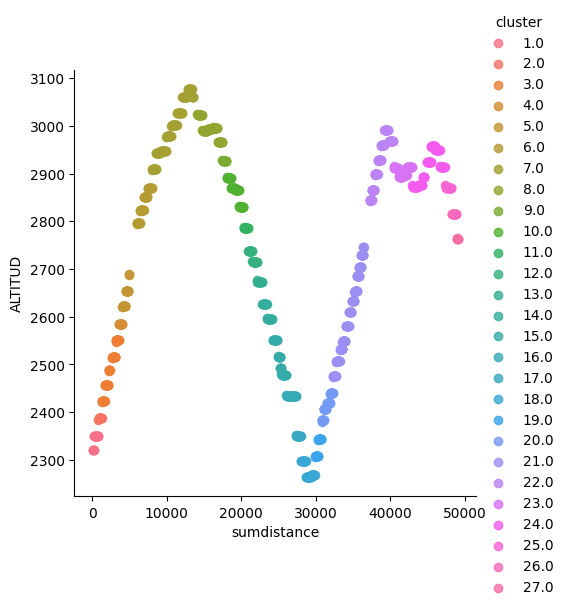

In [196]:
def sdd_clust(data, tol):
    heights = data["ALTITUD"]
    clusters = np.ones(len(heights))
    sdd_cluster=1
    dist = 0
    for i in range(1,len(heights)-1):
        dist = abs(heights[i-1]-heights[i])
        if dist>tol:
            sdd_cluster = sdd_cluster+1
        clusters[i] = sdd_cluster  

    data["cluster"] = clusters    
    return data

def tol_adjust (data, tol=1.9): #empezar con tolerance igual al promedio de alturas 
  #entre puntos consecutivos aproximadamente
  n = 1
  while n>0 :
    tol = tol + 0.1
    data2 = sdd_clust(data, tol)
    frec = data2.cluster.value_counts().to_numpy()
    n = frec[frec<3].shape[0] #number of vey small clusters (forbidden in order to regression to work)
  print('Min gap distance',tol)
  return data2  

datos = tol_adjust(datos, 1.9)
sns.lmplot(x='sumdistance', y='ALTITUD', data=datos, hue='cluster', fit_reg=False)
datos.head()

Corregir alturas

In [197]:
def height_correction(data_clustered, max_points=5):
    clusters = data_clustered.cluster.unique()
    if(len(clusters)>1):
        old_heights = data_clustered['ALTITUD'] 
        corrected = pd.DataFrame()
        last_m = 0
        for i in range(1,len(clusters)):
            #take pair of clusters (left and right)
            grupo1 = data_clustered[data_clustered['cluster']==i].copy()
            grupo2 = data_clustered[data_clustered['cluster']==(i+1)].copy()
            m = np.min([grupo1.shape[0],grupo2.shape[0],max_points]) #largest possible m cannot exceed size of smallest cluster

            #take last and first m-1 points  (important to not include borders which are outliers)
            subgrupo1 = grupo1.iloc[(grupo1.shape[0]-m):grupo1.shape[0]]
            subgrupo2 = grupo2.iloc[1:m] #1 a (m-1)

            #regression points = 2m
            r = pd.concat([subgrupo1,subgrupo2])       
            modelo_z = LinearRegression().fit(r[['sumdistance']],r[['ALTITUD']])

            #predict for all m points of each cluster
            gap_points = pd.concat([grupo1.tail(m),grupo2.head(m)]).copy()
            h_smooth = modelo_z.predict(gap_points[['sumdistance']])
            gap_points['ALTITUD']=h_smooth        
            
            #create final dataset
            corrected = pd.concat([corrected,grupo1.iloc[last_m:(grupo1.shape[0] - m)],gap_points])   
            last_m = m

        corrected = pd.concat([corrected,  grupo2.iloc[last_m:(grupo2.shape[0]+1)]])  
        corrected["old_ALTITUD"] = old_heights
    else:
        print("WARNING: No gaps found (clusters number must be longer than 1")

    return(corrected)

,DATETIME,LATITUD,LONGITUD,ALTITUD,VELOCIDAD,CONSUMO_TOTAL,CPNSUMO_INSTANTANEO,distance,sumdistance,slope,speed,cluster,old_ALTITUD
0,2017-08-15 12:08:38,-3.476464,-79.169121,2321.3,57.89,3091.95,13.40,32.036666,64.278855,0.0,57.665999,1.0,2321.3
1,2017-08-15 12:08:40,-3.476898,-79.169502,2321.3,58.28,3091.96,13.25,64.003520,128.282375,0.0,115.206335,1.0,2321.3
2,2017-08-15 12:08:42,-3.477153,-79.169647,2321.3,58.60,3091.97,13.65,32.480600,160.762975,0.0,58.465080,1.0,2321.3
3,2017-08-15 12:08:44,-3.477430,-79.169754,2321.3,59.17,3091.98,13.75,32.861444,193.624419,0.0,59.150599,1.0,2321.3
4,2017-08-15 12:08:46,-3.477718,-79.169830,2321.3,59.91,3091.99,13.70,32.951891,226.576310,0.0,59.313405,1.0,2321.3


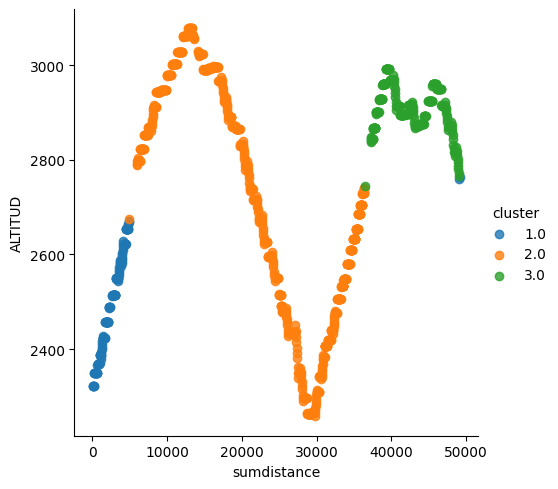

In [198]:
datos2 = height_correction(datos,5)
datos2 = sdd_clust(datos2, 33.41)
sns.lmplot(x='sumdistance', y='ALTITUD', data=datos2, hue='cluster', fit_reg=False)
datos2.head()

Recalcular pendientes

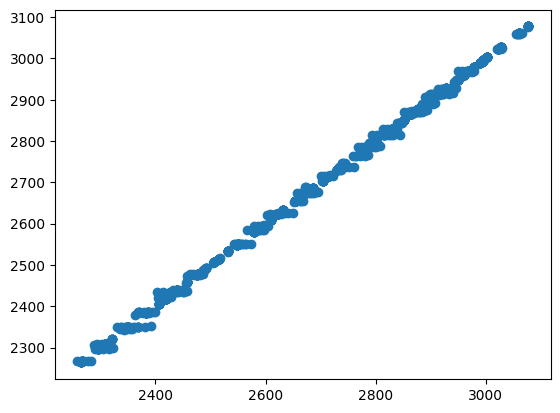

In [202]:
datos2["last_height"] = datos2["ALTITUD"].shift(1)
datos2["old_slope"] = datos2["slope"]
datos2["slope"] = slopes = (datos2["ALTITUD"]-datos2["last_height"])/datos2["distance"]
plt.scatter(datos2["ALTITUD"],datos2["old_ALTITUD"])
plt.show()

Producir archivo final

In [200]:
datosfinales = datos2.copy()
datosfinales.reset_index(drop=True, inplace=True)
datosfinales = datosfinales[["DATETIME","LATITUD","LONGITUD","ALTITUD","VELOCIDAD","CONSUMO_TOTAL","CPNSUMO_INSTANTANEO","slope", "speed","old_ALTITUD","old_slope"]]
datosfinales.to_csv("datasets/datos_corregidos.csv", index=False)